In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tangram as tg 
import numpy as np 

In [2]:
#Spatial data 
dataFolder='./processed_mouse_Ileum/tangram/mapping/'

ad_spatial=sc.read(dataFolder+'ST_gene_by_cell.csv').transpose()
ad_spatial.var_names_make_unique()

In [3]:
#Single cell data 
ad_sc=sc.read(dataFolder+'GSE92332_atlas_UMIcounts.txt',sep='\t').transpose()

In [4]:
#merge data after applying tangram 
ad_tangram=sc.read_h5ad(dataFolder+'sc_genes_spatial_cell.h5ad')

In [5]:
# cell by gene matrix 
print(ad_spatial.shape) 
print(ad_sc.shape)
print(ad_tangram.shape)

(7416, 241)
(7216, 15971)
(7416, 15971)


In [6]:
coordinates = pd.read_csv(dataFolder+"tissue_positions_list.csv", index_col=0,header=None)
#counts = sc.read_csv("./pnas.1912459116.sd12.csv").transpose()
#adata_merfish = counts[coordinates.index, :]
ad_spatial.obsm["spatial"] = coordinates.to_numpy()
ad_tangram.obsm["spatial"] = coordinates.to_numpy()

In [7]:
#load the already clusterd and cell type name file 

cluster= pd.read_csv(dataFolder+'louvain_cluster.dat',sep=',',index_col=0,header=0)
cluster=cluster.to_numpy()
ctname=pd.read_csv(dataFolder+'BiologicalNameOfCT.dat',sep='\t',index_col=0,header=None)
ctname=ctname.to_numpy()
new_cluster_names=ctname[:,0]

ad_spatial.obs['knownClusters'] = cluster.astype(str)
ad_tangram.obs['knownClusters'] = cluster.astype(str)


print('ct name',new_cluster_names)

ct name ['B_Follicular_Circulating' 'B_Plasma' 'Endothelial'
 'Enterocyte_Bottom_Villus' 'Enterocyte_Mid_Villus'
 'Enterocyte_Top_Villus' 'Goblet' 'ICC' 'Macrophage_p_DC'
 'Myenteric_Plexus' 'Paneth' 'Pericyte' 'Smooth_Muscle' 'Stem_p_TA'
 'Stromal' 'T_CD4p' 'T_CD8p' 'Telocyte' 'Tuft']


In [8]:
sc.pp.normalize_total(ad_spatial, inplace=True)
sc.pp.log1p(ad_spatial)

#sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
#sc.pl.highly_variable_genes(adata,show=False,save='.png')

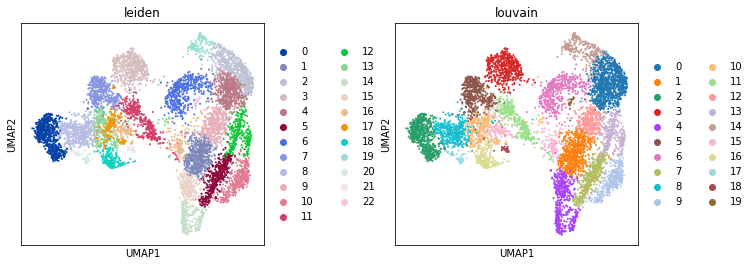

In [9]:
sc.pp.pca(ad_spatial)
sc.pp.neighbors(ad_spatial)
sc.tl.umap(ad_spatial)
sc.tl.leiden(ad_spatial, resolution=1.5)
sc.tl.louvain(ad_spatial,resolution=1.5)


plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(ad_spatial, color=["leiden","louvain"], wspace=0.4,show=True, save='_spatial_leiden_louvain.png')

ad_spatial.obs['knownClusters'] = ad_spatial.obs['knownClusters'].cat.rename_categories(new_cluster_names)

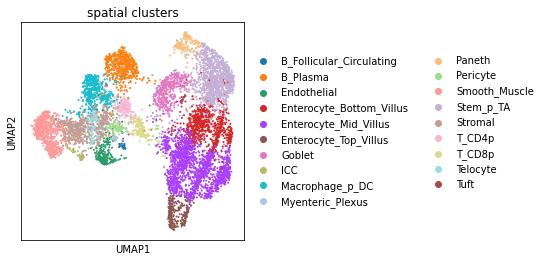

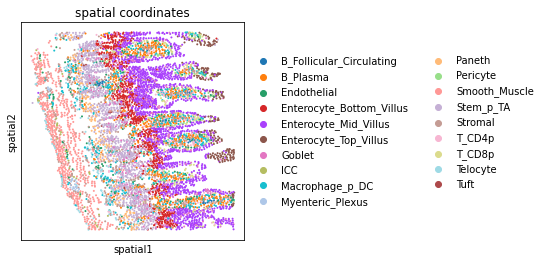

In [10]:
sc.pl.umap(ad_spatial, color="knownClusters",title='spatial clusters',show=True,save='_spatial_known_clusters.png')
sc.pl.embedding(ad_spatial, basis="spatial", color="knownClusters",title='spatial coordinates')

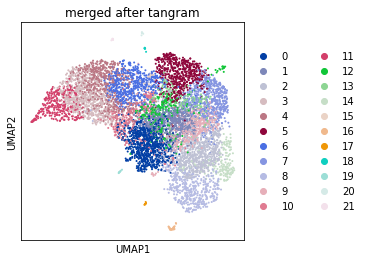

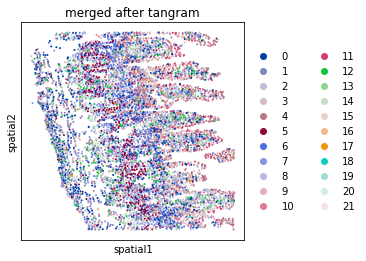

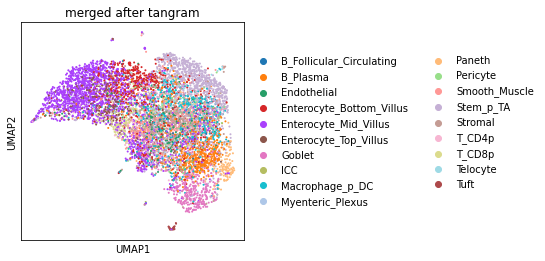

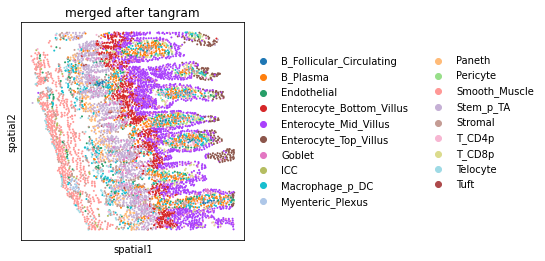

In [12]:
sc.pp.normalize_total(ad_tangram, inplace=True)
sc.pp.log1p(ad_tangram)

sc.pp.pca(ad_tangram)
sc.pp.neighbors(ad_tangram)
sc.tl.umap(ad_tangram)
sc.tl.leiden(ad_tangram, key_added="leiden")

sc.pl.umap(ad_tangram, color=["leiden"],wspace=0.4,show=True,title='merged after tangram',save='_merged_leiden.png')
sc.pl.embedding(ad_tangram, basis="spatial", color="leiden",title='merged after tangram')


ad_tangram.obs['knownClusters'] = ad_tangram.obs['knownClusters'].cat.rename_categories(new_cluster_names)
sc.pl.umap(ad_tangram, color=['knownClusters'],wspace=0.4,show=True,title='merged after tangram',save='_merged_known_clusters.png')
sc.pl.embedding(ad_tangram, basis="spatial", color="knownClusters",title='merged after tangram')

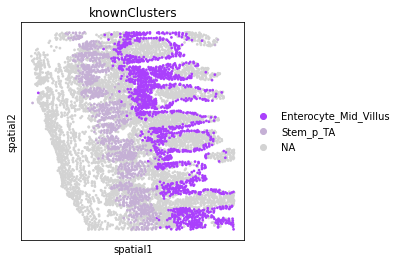

In [14]:
sc.pl.embedding(ad_spatial, basis='spatial',color="knownClusters", groups=["Enterocyte_Mid_Villus", "Stem_p_TA"], alpha=1,size=30)


In [15]:
genesum=np.sum(ad_spatial.X,axis=0)
genemean=np.mean(ad_spatial.X,axis=0)
cellsum=np.sum(ad_spatial.X,axis=1)
print(genesum.shape,genemean.shape,cellsum.shape)
#df=pd.DataFrame(data=adata.X.transpose(), index=adata.var_names , columns=adata.obs_names)
#df.to_csv("xxoutput_filter_"+filename+".csv")
cellname=ad_spatial.obs_names.to_numpy()
genename_spatial=ad_spatial.var_names.to_numpy()
genename_merged=ad_tangram.var_names.to_numpy()

#genename=genename.reshape((len(genename),1))

index=np.argsort(-genesum)
#Top 20 gene sorted according to their mean expression in spatial data 
for i in range(20):
    print(genename_spatial[index[i]],genemean[index[i]])
    
  
#somehow tangram make all the gene name in lowercase letter 
genename_merged = [each_string.capitalize() for each_string in genename_merged]

common_genes=set(genename_spatial).intersection(set(genename_merged))

print('\n\ncommon',common_genes)

(241,) (241,) (7416,)
Neat1 1.4161657
Slc51a 0.9736351
Slc5a1 0.94674546
Txndc5 0.92952883
Clca3b 0.835351
Sdc1 0.81116843
Nlrp6 0.76421785
Cps1 0.74084425
Acta2 0.71616846
Vim 0.5810453
Apob 0.5692399
Maoa 0.55782557
H2-Eb1 0.5164484
Ifnar1 0.48109952
Net1 0.4795036
Fzd5 0.46253517
Lpar1 0.41800344
Cd44 0.39973825
Slc12a2 0.3623207
Tspan13 0.33458102


common {'Il10', 'Tbx21', 'Cnr1', 'Net1', 'Hrh4', 'Gpr34', 'Lpar5', 'Lpar6', 'Ltb4r1', 'Cd8b1', 'Ptger1', 'Adrb1', 'Slc2a2', 'Prf1', 'Chrm3', 'S1pr2', 'Ms4a1', 'Tnfrsf21', 'Smo', 'Tspan13', 'Ffar2', 'Lct', 'Fzd8', 'Cd3e', 'Itgae', 'Tpsb2', 'Pzp', 'Txndc5', 'Plb1', 'Lrmp', 'Sox4', 'Gipr', 'Vim', 'Ffar4', 'Cd79b', 'Klk1', 'Chrm1', 'Glp1r', 'Hrh2', 'Fzd1', 'Galr1', 'Adgrd1', 'Cxcr5', 'Il7r', 'Lamp3', 'Trpm5', 'Sstr3', 'Sstr2', 'Cd34', 'Nlrp6', 'Adgrf5', 'Ifnar1', 'Tbxa2r', 'Cd27', 'Tm4sf4', 'Cysltr1', 'Slc51a', 'Adrb2', 'S1pr4', 'Scn3a', 'Avil', 'Adra2a', 'Fzd2', 'Neurog3', 'Nt5e', 'Fzd3', 'Cysltr2', 'Ada', 'Clca3b', 'Rcor2', 'Elavl3', 'Hrh

In [16]:
new_cluster_names

array(['B_Follicular_Circulating', 'B_Plasma', 'Endothelial',
       'Enterocyte_Bottom_Villus', 'Enterocyte_Mid_Villus',
       'Enterocyte_Top_Villus', 'Goblet', 'ICC', 'Macrophage_p_DC',
       'Myenteric_Plexus', 'Paneth', 'Pericyte', 'Smooth_Muscle',
       'Stem_p_TA', 'Stromal', 'T_CD4p', 'T_CD8p', 'Telocyte', 'Tuft'],
      dtype=object)

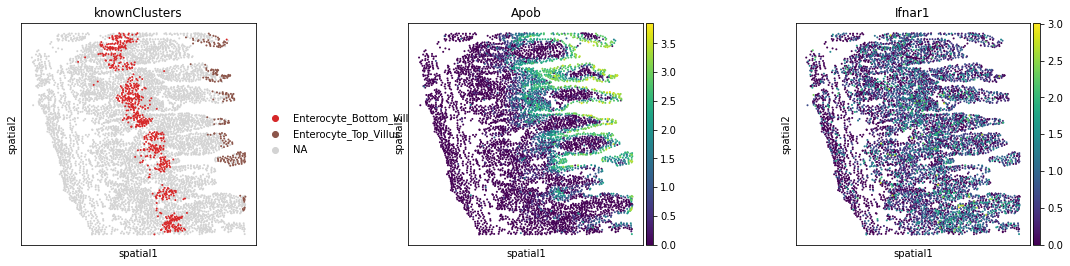

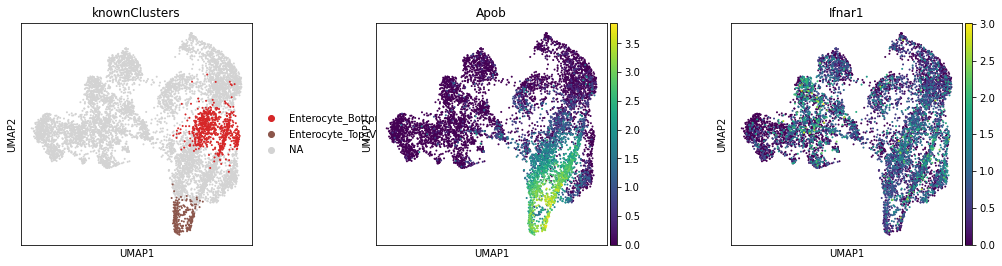

In [17]:
#plot genes and cell types on spatial data 
sc.pl.embedding(ad_spatial, basis='spatial',wspace=0.5,
color=["knownClusters", "Apob","Ifnar1" ],
groups=["Enterocyte_Bottom_Villus", "Enterocyte_Top_Villus"
])

sc.pl.umap(ad_spatial, color=["knownClusters", "Apob","Ifnar1" ],
wspace=0.4,show=True,
groups=["Enterocyte_Bottom_Villus", "Enterocyte_Top_Villus"
])

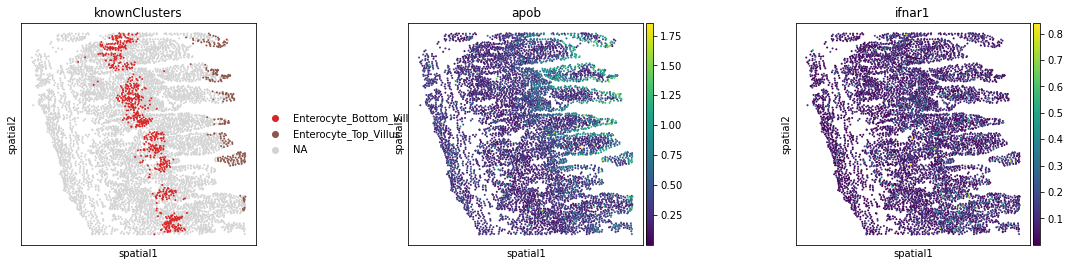

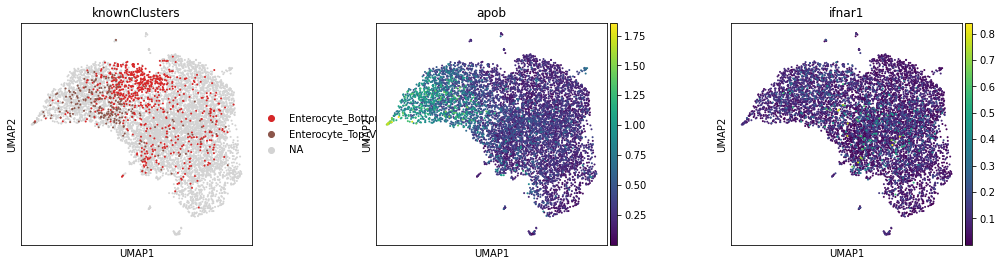

In [18]:
#plot genes and cell types on mapping merged data 
sc.pl.embedding(ad_tangram, basis='spatial',wspace=0.5,
color=["knownClusters", "apob","ifnar1" ],
groups=["Enterocyte_Bottom_Villus", "Enterocyte_Top_Villus"
])

sc.pl.umap(ad_tangram, color=["knownClusters", "apob","ifnar1" ],
wspace=0.4,show=True,
groups=["Enterocyte_Bottom_Villus", "Enterocyte_Top_Villus"
])


In [19]:
ad_spatial.write_h5ad(dataFolder+'saveall_spatial')
ad_tangram.write_h5ad(dataFolder+'saveall_merged')